In [ ]:
from ultralytics import YOLO
import cv2

# Load the trained YOLO model
model = YOLO(r"D:\My_Projects\Sponsorlytix_Assignment\best.pt")  # Update with the correct path

# Load an input image
image_path = r"D:\My_Projects\Sponsorlytix_Assignment\Data\Uppercut.jpg"  # Update with your image path

# Run inference
results = model(image_path, conf=0.5)  # Adjust confidence threshold if needed

# Show results
for result in results:
    result.show()  # Display the image with detections
    result.save(filename="output_3.jpg")  # Save the output image



image 1/1 D:\My_Projects\Sponsorlytix_Assignment\Data\Uppercut.jpg: 384x640 1 Punching bag, 1 Uppercut, 95.4ms
Speed: 1.7ms preprocess, 95.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 1 Punching bag, 1 Uppercut, 267.3ms
Speed: 4.8ms preprocess, 267.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


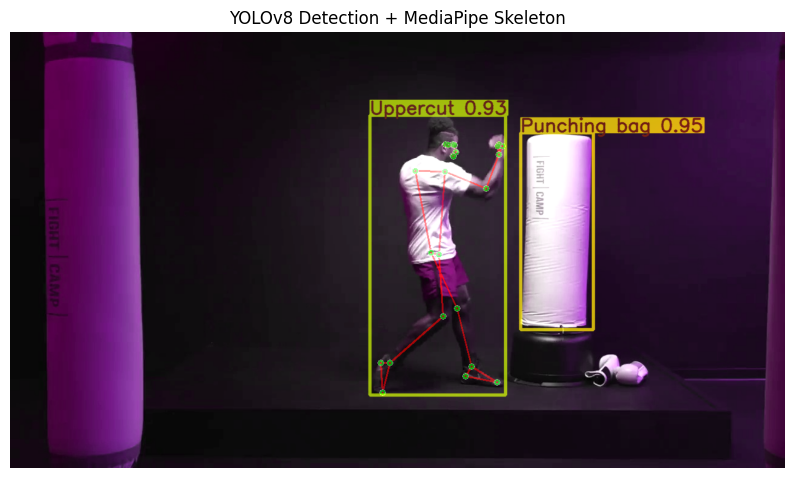

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from ultralytics import YOLO

# Load YOLO model
model = YOLO(r"D:\My_Projects\Sponsorlytix_Assignment\best.pt")  # Update path

# Load an input image
image_path = r"D:\My_Projects\Sponsorlytix_Assignment\Data\Uppercut.jpg"  # Update path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for Matplotlib

# Run YOLO inference
results = model(image_rgb, conf=0.5)  # Adjust confidence threshold
# print(results)
result = results[0]

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils  # Utility for drawing skeleton
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Process the image for skeleton detection
pose_results = pose.process(image_rgb)

# Draw YOLO detections
yolo_image = result.plot()  # YOLO plots bounding boxes

# Overlay the skeleton
if pose_results.pose_landmarks:
    # Draw the skeleton connections
    mp_drawing.draw_landmarks(
        image, 
        pose_results.pose_landmarks, 
        mp_pose.POSE_CONNECTIONS,  # Connect keypoints
        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),  # Keypoints
        mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2)   # Lines
    )

# Overlay YOLO results & skeleton
final_image = cv2.addWeighted(yolo_image, 0.8, image, 0.6, 0)

# Plot the final image with YOLO detections + Skeleton
plt.figure(figsize=(10, 6))
plt.imshow(final_image)
plt.axis("off")
plt.title("YOLOv8 Detection + MediaPipe Skeleton")
plt.show()



0: 384x640 1 Punching bag, 1 Uppercut, 156.8ms
Speed: 2.7ms preprocess, 156.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


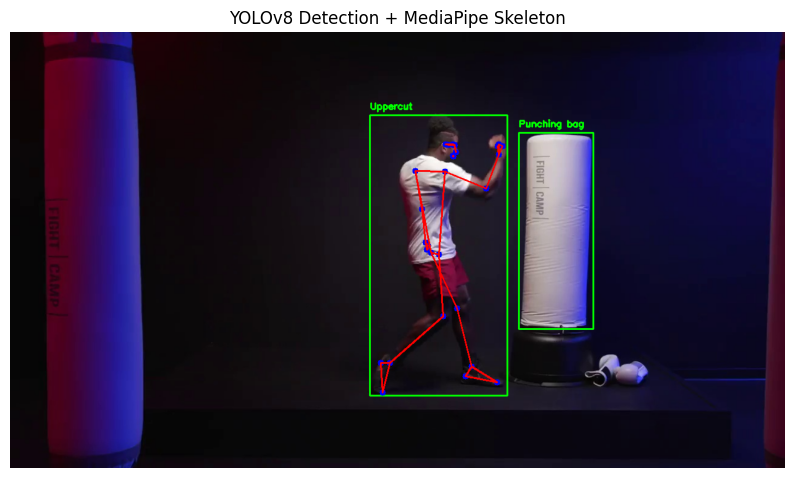


frame:{
    'Boxer':{
        'Punch': 'Uppercut',
        'Landing': 'Missed' 
    },
    'Punching bag':{
        'Action': 'Standing',
        'Landing': 'NAN'
    }
}



In [21]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLO model
model = YOLO(r"D:\My_Projects\Sponsorlytix_Assignment\best.pt")  # Update path

# Load an input image
image_path = r"D:\My_Projects\Sponsorlytix_Assignment\Data\Uppercut.jpg"  # Update path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run YOLO inference
results = model(image, conf=0.25)
result = results[0]

# Extract YOLO detections
boxer_box, bag_box = None, None
punch_type = "Unknown"
for obj in result.boxes:
    label = result.names[int(obj.cls)]
    x1, y1, x2, y2 = map(int, obj.xyxy[0])
    
    if label == "Uppercut" or label == "Jab":  # Boxer detected
        boxer_box = (x1, y1, x2, y2)
        punch_type = label
    elif label == "Punching bag":
        bag_box = (x1, y1, x2, y2)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
pose_results = pose.process(image_rgb)

# Extract hand (fist) keypoints
landing = "Missed"
if pose_results.pose_landmarks:
    right_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
    left_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]
    
    # Convert normalized coordinates to image scale
    img_w, img_h = image.shape[1], image.shape[0]
    right_fist = (int(right_wrist.x * img_w), int(right_wrist.y * img_h))
    left_fist = (int(left_wrist.x * img_w), int(left_wrist.y * img_h))
    
    # Check if fist is inside punching bag's bounding box
    if bag_box:
        bx1, by1, bx2, by2 = bag_box
        if bx1 < right_fist[0] < bx2 and by1 < right_fist[1] < by2:
            landing = "Punching bag"
        elif bx1 < left_fist[0] < bx2 and by1 < left_fist[1] < by2:
            landing = "Punching bag"

# Print frame output in required format
frame_output = f"""
frame:{{
    'Boxer':{{
        'Punch': '{punch_type}',
        'Landing': '{landing}' 
    }},
    'Punching bag':{{
        'Action': 'Standing',
        'Landing': 'NAN'
    }}
}}
"""


# Draw bounding boxes on image
for obj in result.boxes:
    x1, y1, x2, y2 = map(int, obj.xyxy[0])
    label = result.names[int(obj.cls)]
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Draw skeleton keypoints
if pose_results.pose_landmarks:
    connections = mp_pose.POSE_CONNECTIONS
    for landmark in pose_results.pose_landmarks.landmark:
        x, y = int(landmark.x * img_w), int(landmark.y * img_h)
        cv2.circle(image_rgb, (x, y), 5, (0, 0, 255), -1)

    # Draw skeleton lines
    for connection in connections:
        x1, y1 = int(pose_results.pose_landmarks.landmark[connection[0]].x * img_w), int(pose_results.pose_landmarks.landmark[connection[0]].y * img_h)
        x2, y2 = int(pose_results.pose_landmarks.landmark[connection[1]].x * img_w), int(pose_results.pose_landmarks.landmark[connection[1]].y * img_h)
        cv2.line(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Plot the result image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection + MediaPipe Skeleton")
plt.show()


print(frame_output)


0: 384x640 1 Jab, 1 Punching bag, 281.7ms
Speed: 4.5ms preprocess, 281.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


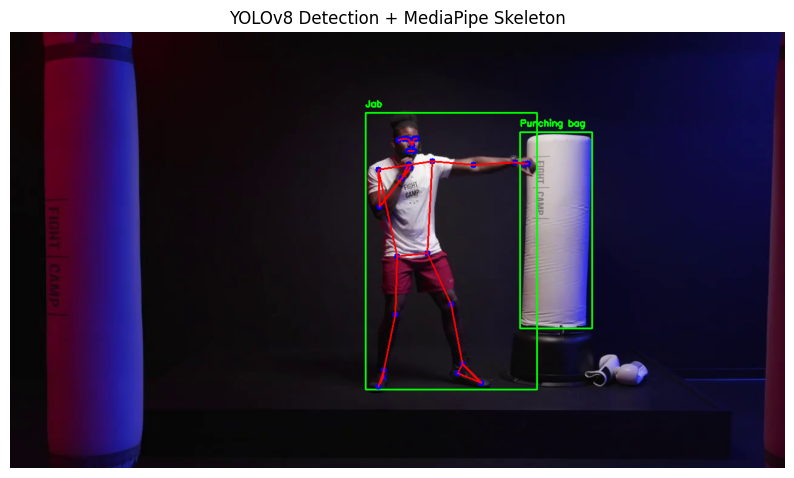


frame:{
    'Boxer':{
        'Punch': 'Jab',
        'Landing': 'Missed' 
    },
    'Punching bag':{
        'Action': 'Standing',
        'Landing': 'NAN'
    }
}



In [22]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLO model
model = YOLO(r"D:\My_Projects\Sponsorlytix_Assignment\best.pt")  # Update path

# Load an input image
image_path = r"D:\My_Projects\Sponsorlytix_Assignment\Data\Jab.jpg"  # Update path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run YOLO inference
results = model(image, conf=0.25)
result = results[0]

# Extract YOLO detections
boxer_box, bag_box = None, None
punch_type = "Unknown"
for obj in result.boxes:
    label = result.names[int(obj.cls)]
    x1, y1, x2, y2 = map(int, obj.xyxy[0])
    
    if label == "Uppercut" or label == "Jab":  # Boxer detected
        boxer_box = (x1, y1, x2, y2)
        punch_type = label
    elif label == "Punching bag":
        bag_box = (x1, y1, x2, y2)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
pose_results = pose.process(image_rgb)

# Extract hand (fist) keypoints
landing = "Missed"
if pose_results.pose_landmarks:
    right_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
    left_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]
    
    # Convert normalized coordinates to image scale
    img_w, img_h = image.shape[1], image.shape[0]
    right_fist = (int(right_wrist.x * img_w), int(right_wrist.y * img_h))
    left_fist = (int(left_wrist.x * img_w), int(left_wrist.y * img_h))
    
    # Check if fist is inside punching bag's bounding box
    if bag_box:
        bx1, by1, bx2, by2 = bag_box
        if bx1 < right_fist[0] < bx2 and by1 < right_fist[1] < by2:
            landing = "Punching bag"
        elif bx1 < left_fist[0] < bx2 and by1 < left_fist[1] < by2:
            landing = "Punching bag"

# Print frame output in required format
frame_output = f"""
frame:{{
    'Boxer':{{
        'Punch': '{punch_type}',
        'Landing': '{landing}' 
    }},
    'Punching bag':{{
        'Action': 'Standing',
        'Landing': 'NAN'
    }}
}}
"""


# Draw bounding boxes on image
for obj in result.boxes:
    x1, y1, x2, y2 = map(int, obj.xyxy[0])
    label = result.names[int(obj.cls)]
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Draw skeleton keypoints
if pose_results.pose_landmarks:
    connections = mp_pose.POSE_CONNECTIONS
    for landmark in pose_results.pose_landmarks.landmark:
        x, y = int(landmark.x * img_w), int(landmark.y * img_h)
        cv2.circle(image_rgb, (x, y), 5, (0, 0, 255), -1)

    # Draw skeleton lines
    for connection in connections:
        x1, y1 = int(pose_results.pose_landmarks.landmark[connection[0]].x * img_w), int(pose_results.pose_landmarks.landmark[connection[0]].y * img_h)
        x2, y2 = int(pose_results.pose_landmarks.landmark[connection[1]].x * img_w), int(pose_results.pose_landmarks.landmark[connection[1]].y * img_h)
        cv2.line(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Plot the result image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection + MediaPipe Skeleton")
plt.show()


print(frame_output)


0: 384x640 1 Jab, 1 Punching bag, 288.9ms
Speed: 2.8ms preprocess, 288.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


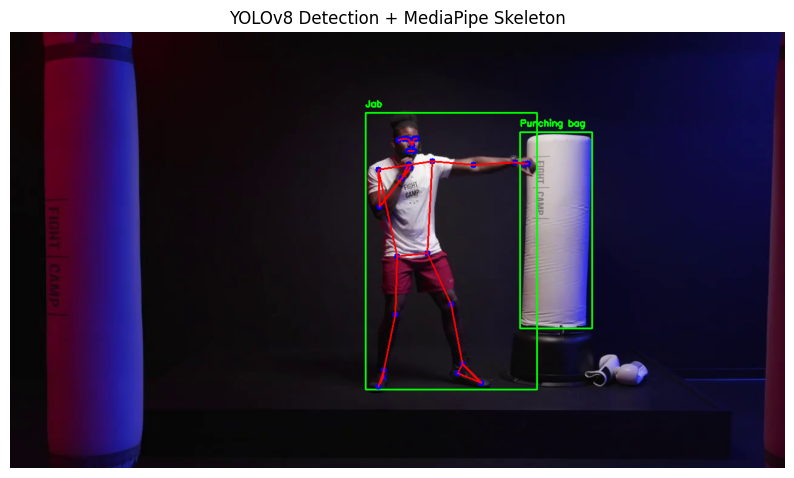

{
    "frame": {
        "Boxer": {
            "Punch": "Jab",
            "Landing": "Head"
        },
        "Punching bag": {
            "Action": "Standing",
            "Landing": "NAN"
        }
    }
}


In [24]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLO model
model = YOLO(r"D:\My_Projects\Sponsorlytix_Assignment\best.pt")  # Update path

# Load an input image
image_path = r"D:\My_Projects\Sponsorlytix_Assignment\Data\Jab.jpg"  # Update path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run YOLO inference
results = model(image, conf=0.25)
result = results[0]

# Extract YOLO detections
boxer_box, bag_box = None, None
punch_type = "Unknown"
for obj in result.boxes:
    label = result.names[int(obj.cls)]
    x1, y1, x2, y2 = map(int, obj.xyxy[0])
    
    if label in ["Uppercut", "Jab"]:  # Detect Boxer Punch
        boxer_box = (x1, y1, x2, y2)
        punch_type = label
    elif label == "Punching bag":
        bag_box = (x1, y1, x2, y2)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
pose_results = pose.process(image_rgb)

# Extract hand (fist) keypoints
landing = "Missed"
if pose_results.pose_landmarks:
    right_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
    left_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]
    
    # Convert normalized coordinates to image scale
    img_w, img_h = image.shape[1], image.shape[0]
    right_fist = (int(right_wrist.x * img_w), int(right_wrist.y * img_h))
    left_fist = (int(left_wrist.x * img_w), int(left_wrist.y * img_h))
    
    # Expand the fist's region for better contact detection
    hand_size = 10
    right_fist_box = (right_fist[0] - hand_size, right_fist[1] - hand_size, 
                      right_fist[0] + hand_size, right_fist[1] + hand_size)
    left_fist_box = (left_fist[0] - hand_size, left_fist[1] - hand_size, 
                     left_fist[0] + hand_size, left_fist[1] + hand_size)

    # Function to check bounding box intersection
    def is_intersecting(box1, box2):
        x1, y1, x2, y2 = box1
        bx1, by1, bx2, by2 = box2
        return not (x2 < bx1 or x1 > bx2 or y2 < by1 or y1 > by2)

    # Check for contact with the punching bag
    if bag_box:
        if is_intersecting(right_fist_box, bag_box) or is_intersecting(left_fist_box, bag_box):
            landing = "Head"

# Print frame output in the required format
frame_output = {
    "frame": {
        "Boxer": {
            "Punch": punch_type,
            "Landing": landing
        },
        "Punching bag": {
            "Action": "Standing",
            "Landing": "NAN"
        }
    }
}

# Draw bounding boxes on image
for obj in result.boxes:
    x1, y1, x2, y2 = map(int, obj.xyxy[0])
    label = result.names[int(obj.cls)]
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Draw skeleton keypoints
if pose_results.pose_landmarks:
    connections = mp_pose.POSE_CONNECTIONS
    for landmark in pose_results.pose_landmarks.landmark:
        x, y = int(landmark.x * img_w), int(landmark.y * img_h)
        cv2.circle(image_rgb, (x, y), 5, (0, 0, 255), -1)

    # Draw skeleton lines
    for connection in connections:
        x1, y1 = int(pose_results.pose_landmarks.landmark[connection[0]].x * img_w), int(pose_results.pose_landmarks.landmark[connection[0]].y * img_h)
        x2, y2 = int(pose_results.pose_landmarks.landmark[connection[1]].x * img_w), int(pose_results.pose_landmarks.landmark[connection[1]].y * img_h)
        cv2.line(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Plot the result image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection + MediaPipe Skeleton")
plt.show()

# Print frame output in JSON format
import json
print(json.dumps(frame_output, indent=4))



0: 384x640 1 Punching bag, 1 Hook, 286.1ms
Speed: 5.3ms preprocess, 286.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


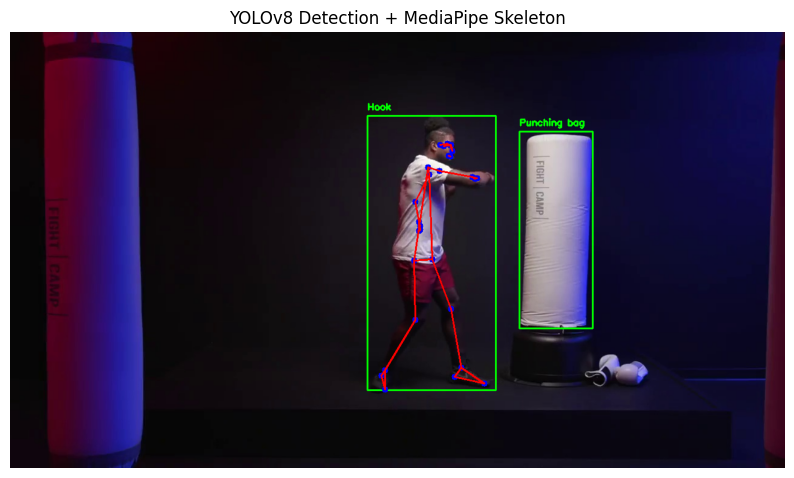

{
    "frame": {
        "Boxer": {
            "Punch": "Hook",
            "Landing": "Missed"
        },
        "Punching bag": {
            "Action": "Standing",
            "Landing": "NAN"
        }
    }
}


In [26]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLO model
model = YOLO(r"D:\My_Projects\Sponsorlytix_Assignment\best.pt")  # Update path

# Load an input image
image_path = r"D:\My_Projects\Sponsorlytix_Assignment\Data\Hook.jpg"  # Update path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run YOLO inference
results = model(image, conf=0.25)
result = results[0]

# Extract YOLO detections
boxer_box, bag_box = None, None
punch_type = "Hook"
for obj in result.boxes:
    label = result.names[int(obj.cls)]
    x1, y1, x2, y2 = map(int, obj.xyxy[0])
    
    if label in ["Uppercut", "Jab"]:  # Detect Boxer Punch
        boxer_box = (x1, y1, x2, y2)
        punch_type = label
    elif label == "Punching bag":
        bag_box = (x1, y1, x2, y2)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
pose_results = pose.process(image_rgb)

# Extract hand (fist) keypoints
landing = "Missed"
if pose_results.pose_landmarks:
    right_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
    left_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]
    
    # Convert normalized coordinates to image scale
    img_w, img_h = image.shape[1], image.shape[0]
    right_fist = (int(right_wrist.x * img_w), int(right_wrist.y * img_h))
    left_fist = (int(left_wrist.x * img_w), int(left_wrist.y * img_h))
    
    # Expand the fist's region for better contact detection
    hand_size = 10
    right_fist_box = (right_fist[0] - hand_size, right_fist[1] - hand_size, 
                      right_fist[0] + hand_size, right_fist[1] + hand_size)
    left_fist_box = (left_fist[0] - hand_size, left_fist[1] - hand_size, 
                     left_fist[0] + hand_size, left_fist[1] + hand_size)

    # Function to check bounding box intersection
    def is_intersecting(box1, box2):
        x1, y1, x2, y2 = box1
        bx1, by1, bx2, by2 = box2
        return not (x2 < bx1 or x1 > bx2 or y2 < by1 or y1 > by2)

    # Check for contact with the punching bag
    if bag_box:
        if is_intersecting(right_fist_box, bag_box) or is_intersecting(left_fist_box, bag_box):
            landing = "Head"

# Print frame output in the required format
frame_output = {
    "frame": {
        "Boxer": {
            "Punch": punch_type,
            "Landing": landing
        },
        "Punching bag": {
            "Action": "Standing",
            "Landing": "NAN"
        }
    }
}

# Draw bounding boxes on image
for obj in result.boxes:
    x1, y1, x2, y2 = map(int, obj.xyxy[0])
    label = result.names[int(obj.cls)]
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Draw skeleton keypoints
if pose_results.pose_landmarks:
    connections = mp_pose.POSE_CONNECTIONS
    for landmark in pose_results.pose_landmarks.landmark:
        x, y = int(landmark.x * img_w), int(landmark.y * img_h)
        cv2.circle(image_rgb, (x, y), 5, (0, 0, 255), -1)

    # Draw skeleton lines
    for connection in connections:
        x1, y1 = int(pose_results.pose_landmarks.landmark[connection[0]].x * img_w), int(pose_results.pose_landmarks.landmark[connection[0]].y * img_h)
        x2, y2 = int(pose_results.pose_landmarks.landmark[connection[1]].x * img_w), int(pose_results.pose_landmarks.landmark[connection[1]].y * img_h)
        cv2.line(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Plot the result image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("YOLOv8 Detection + MediaPipe Skeleton")
plt.show()

# Print frame output in JSON format
import json
print(json.dumps(frame_output, indent=4))
